In [1]:
from typing import List

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio

#### Download dataset

In [2]:
dataset = torchaudio.datasets.YESNO(root='.', download=True)

In [3]:
len(dataset)

60

##### An example utterance

In [4]:
wave, _ = torchaudio.load('waves_yesno/0_0_0_0_1_1_1_1.wav')
wave.shape

torch.Size([1, 50800])

In [5]:
example_item = dataset[0]
example_item

(tensor([[ 3.0518e-05,  6.1035e-05,  3.0518e-05,  ..., -1.8616e-03,
          -2.2583e-03, -1.3733e-03]]),
 8000,
 [0, 0, 0, 0, 1, 1, 1, 1])

In [6]:
example_waveform, sample_rate, example_label = example_item

In [7]:
def plot_waveform(waveform, sr=8000):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    figure, axes = plt.subplots(num_channels, 1)
    axes.plot(time_axis, waveform[0], linewidth=1)
    axes.grid(True)
    plt.show(block=False)

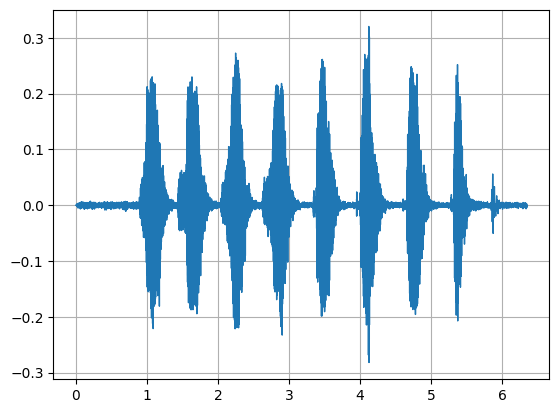

In [8]:
plot_waveform(example_waveform, sample_rate)

In [9]:
feat_extractor = torchaudio.transforms.MFCC(sample_rate=sample_rate, n_mfcc=20)
example_feature = feat_extractor(example_waveform)

example_feature.shape, example_feature

(torch.Size([1, 20, 255]),
 tensor([[[-588.8540, -470.5740, -420.1156,  ..., -444.7209, -439.5280,
           -451.6681],
          [  31.0458,   52.0958,   54.9272,  ...,   48.6369,   54.6375,
             34.4412],
          [  22.5095,   27.2490,   13.8212,  ...,   18.7315,   23.2091,
             29.7234],
          ...,
          [  -9.9515,    6.1422,   -3.4621,  ...,   -6.6514,   -2.0521,
              2.8515],
          [ -14.9654,   -6.0978,   -7.4906,  ...,  -10.8089,   -6.3692,
             -8.3595],
          [  -9.7625,   -3.0506,   -2.3251,  ...,   -9.0593,   -6.0059,
            -16.7919]]]))

声学特征有很多种，MFCC 是语音识别中较常用的特征。

![acoustic-feature](/home/zhangjunbo/src/yesno-example-for-undergraduates/pic/acoustic-feature.png)

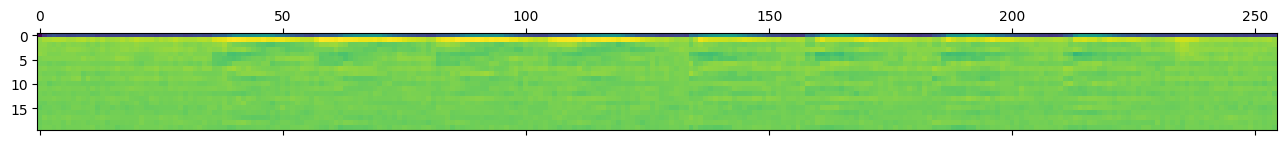

In [10]:
example_feature = example_feature.squeeze(0)
plt.matshow(example_feature)

### A better `DataSet`

In [11]:
index_to_char = [c for c in 'eYESNO ']
char_to_index = {c: i for i, c in enumerate(index_to_char)}

In [12]:
class YesnoDataset(torchaudio.datasets.YESNO):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def _labels_ints_to_text(self, labels: List[int]) -> str:
        text_of_label_int = {0: 'NO', 1: 'YES'}
        return ' '.join([text_of_label_int[label] for label in labels])

    def __getitem__(self, index):
        waveform, _, labels = super().__getitem__(index)
        text = self._labels_ints_to_text(labels)
        labels = torch.IntTensor([char_to_index[c] for c in text])
        return waveform, labels, text

In [13]:
dataset = YesnoDataset(root='.', download=True)

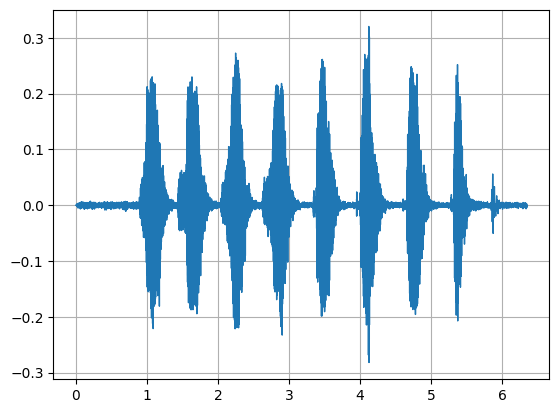

In [14]:
waveform, labels, text = dataset[0]
plot_waveform(waveform)

In [15]:
text, labels, dict(enumerate(index_to_char))

('NO NO NO NO YES YES YES YES',
 tensor([4, 5, 6, 4, 5, 6, 4, 5, 6, 4, 5, 6, 1, 2, 3, 6, 1, 2, 3, 6, 1, 2, 3, 6,
         1, 2, 3], dtype=torch.int32),
 {0: 'e', 1: 'Y', 2: 'E', 3: 'S', 4: 'N', 5: 'O', 6: ' '})

### Define the model

In [16]:
class YesnoNet(nn.Module):
    def __init__(self, feat_dim=20, hidden_size=128):
        super(YesnoNet, self).__init__()
        output_dim = len(index_to_char)
        self.lstm = nn.LSTM(feat_dim, hidden_size, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_size * 2, output_dim)
        self.feat_extractor = torchaudio.transforms.MFCC(sample_rate=8000, n_mfcc=feat_dim)

    def forward(self, x):
        x = self.feat_extractor(x).squeeze(0)
        x = torch.transpose(x, 1, 2)
        output, _ = self.lstm(x)
        output = self.fc(output)
        output = torch.transpose(output, 0, 1)  # 'N T C -> T N C'
        return output.log_softmax(2)

### Let's start training!

In [17]:
torch.manual_seed(1)
train_set, test_set = torch.utils.data.random_split(dataset, [50, 10])

In [18]:
model = YesnoNet()
optimizer = optim.Adam(model.parameters())
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1)
ctc_loss = nn.CTCLoss()
total_epoches = 20

In [19]:
model.train()

YesnoNet(
  (lstm): LSTM(20, 128, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=7, bias=True)
  (feat_extractor): MFCC(
    (amplitude_to_DB): AmplitudeToDB()
    (MelSpectrogram): MelSpectrogram(
      (spectrogram): Spectrogram()
      (mel_scale): MelScale()
    )
  )
)

In [20]:
for epoch in range(total_epoches):
    for feat, label, _ in train_set:
        label, feat = torch.unsqueeze(label, 0), torch.unsqueeze(feat, 0)
        optimizer.zero_grad()
        output = model(feat)
        loss = ctc_loss(output, label, torch.IntTensor([output.shape[0]]), torch.IntTensor([label.shape[1]]))
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch}\tLoss: {loss.item()}')

Epoch 0	Loss: 1.8397321701049805
Epoch 1	Loss: 1.7737153768539429
Epoch 2	Loss: 1.5327917337417603
Epoch 3	Loss: 1.1583954095840454
Epoch 4	Loss: 0.7516840696334839
Epoch 5	Loss: 0.40194040536880493
Epoch 6	Loss: 0.2514305114746094
Epoch 7	Loss: 0.18757635354995728
Epoch 8	Loss: 0.12486808747053146
Epoch 9	Loss: 0.09811263531446457
Epoch 10	Loss: 0.07182665914297104
Epoch 11	Loss: 0.049070004373788834
Epoch 12	Loss: 0.03715882822871208
Epoch 13	Loss: 0.028230972588062286
Epoch 14	Loss: 0.024645674973726273
Epoch 15	Loss: 0.017967943102121353
Epoch 16	Loss: 0.015160764567553997
Epoch 17	Loss: 0.013250105082988739
Epoch 18	Loss: 0.013681597076356411
Epoch 19	Loss: 0.01014114823192358


### Test

In [21]:
model.eval()

YesnoNet(
  (lstm): LSTM(20, 128, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=7, bias=True)
  (feat_extractor): MFCC(
    (amplitude_to_DB): AmplitudeToDB()
    (MelSpectrogram): MelSpectrogram(
      (spectrogram): Spectrogram()
      (mel_scale): MelScale()
    )
  )
)

In [22]:
waveform, _, reference = test_set[0]
waveform.shape

torch.Size([1, 49760])

In [23]:
logits = model(torch.unsqueeze(waveform, 0)).detach()
logits = torch.squeeze(logits, 1)
logits.shape

torch.Size([249, 7])

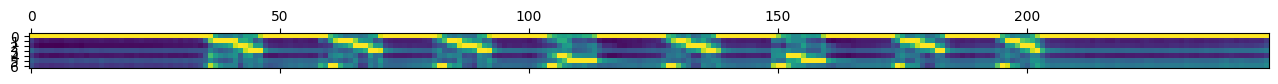

In [24]:
plt.matshow(logits.transpose(0, 1))

##### Greedy search

In [25]:
align = [index_to_char[int(torch.argmax(logit, dim=0).item())] for logit in logits]
' '.join(align)

'e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e Y Y Y Y Y E E S S S e e e e e e e e e e e e e     Y Y Y E E E S S S e e e e e e e e e e e     Y Y Y E E E S S S e e e e e e e e e e e     N N O O O O O O e e e e e e e e e e e e e e     Y Y E E E E S S e e e e e e e e e e e e     N N N O O O O O e e e e e e e e e e e e e e   Y Y Y Y E E E S S e e e e e e e e e e e   Y Y Y E E E S e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e'

In [26]:
result = ''.join([align[i] for i in range(len(align)) if align[i] != 'e' and (i == 0 or align[i] != align[i - 1])])
result

'YES YES YES NO YES NO YES YES'

In [27]:
reference

'YES YES YES NO YES NO YES YES'

### Export the model in TorchScript for deployment

In [28]:
model_scripted = torch.jit.script(model)

In [29]:
model_scripted.save('model.pt')